### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from yaml_parser import GridSearchYamlParser
from fnmatch import fnmatch

## Load Permutation Configs

In [2]:
tune_config = GridSearchYamlParser("./tune.yaml").get_config()["hyperparameters"]

In [3]:
def get_sorted_config_paths(dirpath):
    a = [s for s in os.listdir(dirpath)
         if os.path.isfile(os.path.join(dirpath, s))]
    a.sort(key=lambda s: os.path.getmtime(os.path.join(dirpath, s)))
    for i, f in enumerate(a):
        a[i] = os.path.join(dirpath, f)
    return a

In [4]:
config_paths = get_sorted_config_paths("./configs/")
permutation_configs = [dict(GridSearchYamlParser(p).get_config()["permutation"]["hyperparameters"]) for p in config_paths]

## Collect indices for each item inside the tune config

In [5]:
# Init lists to store indices
indices = {}
for key in tune_config:
        for value in tune_config[key]:
            indices[key + "_" + str(value)] = []

# Iterate over the entire permutation configs and check which one relates to one value of the tuning config
for i, perm in enumerate(permutation_configs):
    for key in tune_config:
        for value in tune_config[key]:
            if perm[key] == value:
                indices[key + "_" + str(value)].append(i)


## Load Tensorboard Summaries

In [6]:
def get_sorted_summary_paths(path):
    paths = []
    for path, subdirs, files in os.walk(path):
        for name in files:
            if fnmatch(name, "*.0"):
                paths.append(os.path.join(path, name))
    return paths

In [7]:
summary_paths = get_sorted_summary_paths("./summaries/")
summaries = [EventAccumulator(path) for path in summary_paths]
for i in range(len(summaries)):
    summaries[i].Reload()

In [8]:
print(summaries[0].scalars.Keys())

['episode/reward_mean', 'episode/reward_min', 'episode/reward_max', 'episode/length_mean', 'episode/length_min', 'episode/length_max', 'losses/loss', 'losses/policy_loss', 'losses/value_loss', 'other/entropy', 'other/clip_fraction', 'other/sequence_length', 'episode/value_mean', 'episode/advantage_mean', 'decay/learning_rate', 'decay/clip_range', 'decay/beta']


In [9]:
_, t, v = zip(*summaries[0].Scalars("episode/reward_mean"))

## Load data and convert to numpy arrays

In [10]:
data_dict = {}
for key in indices:
    if key != "activation_elu" and key != "activation_swish":
        data = []
        for i in indices[key]:
            _, t, v = zip(*summaries[i].Scalars("episode/reward_mean"))
            data.append(list(v))
        data_dict[key] = np.transpose(np.asarray(data), [1, 0])

In [11]:
#activation_data = {
#    "leaky_relu": data_dict["activation_leaky_relu"],
#    #"swish": data_dict["activation_swish"],
#    #"elu": data_dict["activation_elu"],
#    "relu": data_dict["activation_relu"]}

layer_type_data = {
    "gru": data_dict["layer_type_gru"],
    "lstm": data_dict["layer_type_lstm"]}

hidden_state_init_data = {
    "zero": data_dict["hidden_state_init_zero"],
    "one": data_dict["hidden_state_init_one"],
    "mean": data_dict["hidden_state_init_mean"],
    "sample": data_dict["hidden_state_init_sample"]}

hidden_state_size_data = {
    "64": data_dict["hidden_state_size_64"],
    "128": data_dict["hidden_state_size_128"],
    "256": data_dict["hidden_state_size_256"],
    "512": data_dict["hidden_state_size_512"]}

sequence_length_data = {
    "1": data_dict["sequence_length_1"],
    "2": data_dict["sequence_length_2"],
    "4": data_dict["sequence_length_4"],
    "8": data_dict["sequence_length_8"],
    "12": data_dict["sequence_length_12"],
    "16": data_dict["sequence_length_16"],
    "24": data_dict["sequence_length_24"]}

## Line Plots (mean reward)

In [12]:
def plot(steps, data, title, out=None):
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5.5)

    for key, value in data.items():
        ax.plot(steps, value.mean(axis=1), label=key)
        ax.fill_between(steps, value.mean(axis=1) + value.std(axis=1),  value.mean(axis=1) - value.std(axis=1), alpha=0.3)

    leg = ax.legend(title="Sequence Length", loc="lower right")
    ax.set_ylabel("Mean Reward")
    ax.set_ylim([0.2,1])
    ax.set_xlabel("PPO Update")
    ax.set_xlim([0,200])
    ax.set_title("Training Performance")
    if out is not None:
        plt.savefig(out)
    plt.show()

### Sequence Length

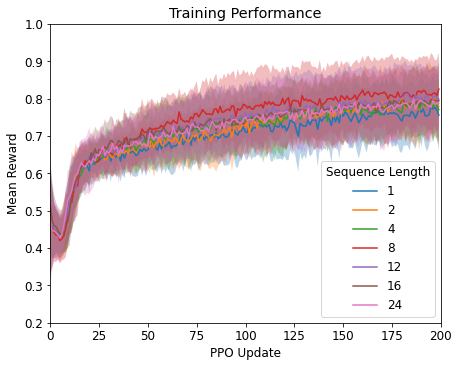

In [13]:
steps = [i for i in range(0, sequence_length_data["1"].shape[0])]
plot(steps, sequence_length_data, "Sequence Length", out="sequence_length_line.png")

### Hidden State Init

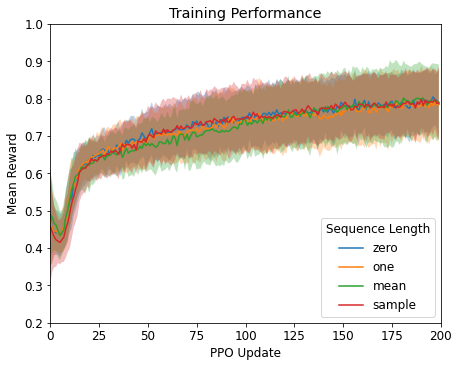

In [14]:
plot(steps, hidden_state_init_data, "Hidden State Init")

### Hidden State Size

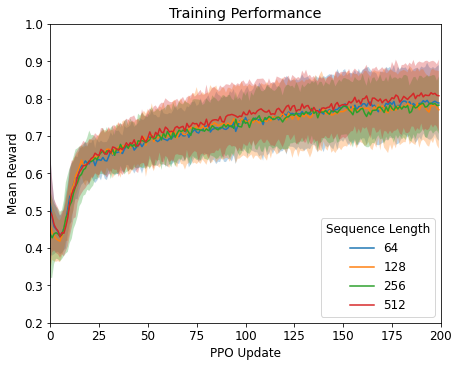

In [15]:
plot(steps, hidden_state_size_data, "Hidden State Size")

### Layer Type

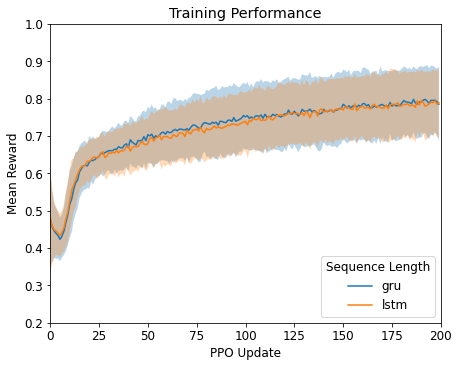

In [16]:
plot(steps, layer_type_data, "Layer Type")

### Activation

In [17]:
#plot(steps, activation_data, "Activation")

NameError: name 'activation_data' is not defined

## Filter runs that achieved mean reward > 0.9

In [20]:
threshold = 0.94
strong_ids = []

for i, summary in enumerate(summaries):
    _, _, v = zip(*summaries[i].Scalars("episode/reward_mean"))
    v = list(v)
    v = np.mean(np.asarray(v[-10:]))
    if v >= threshold:
        strong_ids.append(i)

print(len(strong_ids))

118


In [54]:
scores = {}
for key in tune_config:
        for value in tune_config[key]:
            scores[key + "_" + str(value)] = 0

# filter permutation configs by strong ids
selected_perm_configs = [permutation_configs[i] for i in strong_ids]

for i, perm in enumerate(selected_perm_configs):
    for key in tune_config:
        for value in tune_config[key]:
            if perm[key] == value:
                scores[key + "_" + str(value)] += 1

In [55]:
scores

{'layer_type_gru': 10,
 'layer_type_lstm': 5,
 'hidden_state_init_zero': 4,
 'hidden_state_init_one': 4,
 'hidden_state_init_mean': 6,
 'hidden_state_init_sample': 1,
 'hidden_state_size_64': 5,
 'hidden_state_size_128': 3,
 'hidden_state_size_256': 1,
 'hidden_state_size_512': 6,
 'sequence_length_1': 1,
 'sequence_length_2': 2,
 'sequence_length_4': 2,
 'sequence_length_8': 5,
 'sequence_length_12': 3,
 'sequence_length_16': 1,
 'sequence_length_24': 1}

In [56]:
#activation_frequencies = {
#    "relu": scores["activation_relu"],
#    "leaky_relu": scores["activation_leaky_relu"],
#    "swish": scores["activation_swish"],
#    "elu": scores["activation_elu"]}

layer_type_frequencies = {
    "gru": scores["layer_type_gru"],
    "lstm": scores["layer_type_lstm"]}

hidden_state_init_frequencies = {
    "zero": scores["hidden_state_init_zero"],
    "one": scores["hidden_state_init_one"],
    "mean": scores["hidden_state_init_mean"],
    "sample": scores["hidden_state_init_sample"]}

hidden_state_size_frequencies = {
    "64": scores["hidden_state_size_64"],
    "128": scores["hidden_state_size_128"],
    "256": scores["hidden_state_size_256"],
    "512": scores["hidden_state_size_512"]}

sequence_length_frequencies = {
    "1": scores["sequence_length_1"],
    "2": scores["sequence_length_2"],
    "4": scores["sequence_length_4"],
    "8": scores["sequence_length_8"],
    "12": scores["sequence_length_12"],
    "16": scores["sequence_length_16"],
    "24": scores["sequence_length_24"]}

## Bar Plots (frequency)

In [57]:
def plot_frequency(frequencies, y_label, out=None):
    fig, ax = plt.subplots()
    vals = []
    keys = []
    for k, v in frequencies.items():
        vals.append(v)
        keys.append(k)
    ax.bar(keys, vals, align='center', alpha=0.5, label="Evaluation")
    ax.set_xlabel(y_label)
    ax.set_ylabel('Count')
    ax.set_title("Training Performance")
    if out is not None:
        plt.savefig(out)
    plt.show()

### Sequence Length

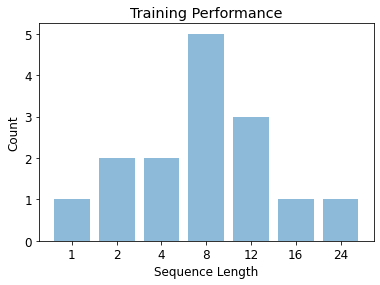

In [58]:
plot_frequency(sequence_length_frequencies, "Sequence Length", "seq_len_bar.png")

### Hidden State Size

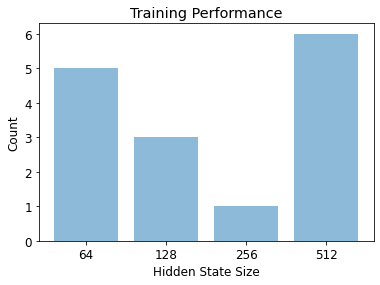

In [59]:
plot_frequency(hidden_state_size_frequencies, "Hidden State Size", "hs_size_bar.png")

### Hidden State Init

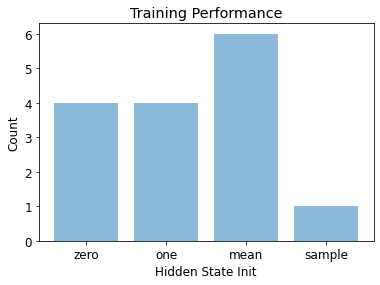

In [60]:
plot_frequency(hidden_state_init_frequencies, "Hidden State Init", "hs_init_bar.png")

### Layer Type

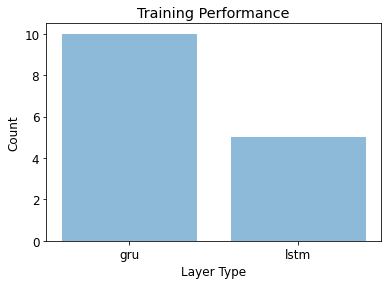

In [61]:
plot_frequency(layer_type_frequencies, "Layer Type", "layer_type_bar.png")

### Activations

In [43]:
plot_frequency(activation_frequencies, "Activation", "activation_bar.png")

NameError: name 'activation_frequencies' is not defined